Data from head and neck cancer patients, sourced from The Cancer Imaging Archive. 
This dataset contains survival time, event indicators, and covariates such as age, treatment type, and tumor stage

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sksurv.preprocessing import OneHotEncoder # could use pd.get_dummies()

# !pip install openpyxl
# %pip install openpyxl  # got it working!



### 1. Kaplan-Meier Analysis
- Generate Kaplan-Meier survival curves for at least two distinct groups (e.g., treatment
type, age group, or tumor stage), ensuring each group has its own plot.
-  For each plot, conduct a log-rank test to compare survival differences between the
groups.


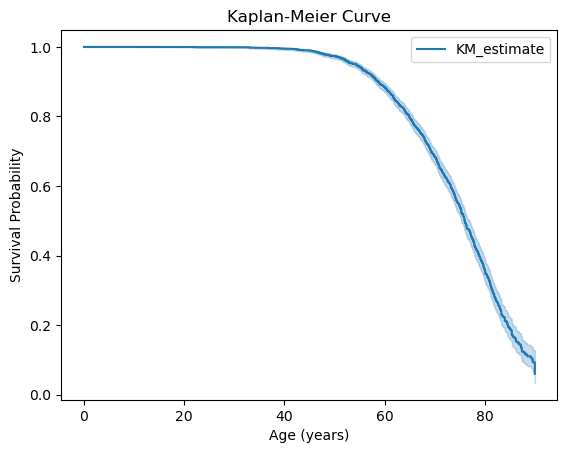

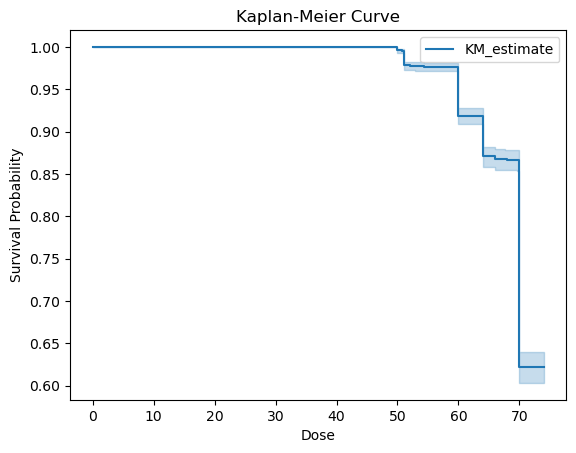

In [39]:
from lifelines import KaplanMeierFitter

# Load the dataset
data1 = pd.read_excel('../Data/RADCURE_Clinical_v04_20241219.xlsx', engine='openpyxl')
data=data1.copy()

#OneHot enconding of status? --> doesnt change anything 
data["Status"] = np.where(data["Status"]=="Dead", 1, 0)

# Fit the Kaplan-Meier estimator
# INSTANTIATE, FIT, PREDICT
kmf = KaplanMeierFitter()
kmf.fit(data['Age'], event_observed=data['Status'])
# if we want to stratify by a particular feature, just fit 2 separate objects 
# 'starify' == looking at survival as fucntion of this variable 
# can index to plot them all (other ways as well?)

# Plot the Kaplan-Meier curve
kmf.plot_survival_function() #intuitive and lots of built in funxality, .print_saummary() 
plt.title('Kaplan-Meier Curve')
plt.xlabel('Age (years)')
plt.ylabel('Survival Probability')
plt.show()


kmf.fit(data['Dose'], event_observed=data['Status'])
# Plot the Kaplan-Meier curve
kmf.plot_survival_function() #intuitive and lots of built in funxality, .print_saummary() 
plt.title('Kaplan-Meier Curve')
plt.xlabel('Dose')
plt.ylabel('Survival Probability')
plt.show()

# log rank test:



### 2. Cox Proportional Hazards Regression
- Perform a Cox regression analysis, including at least three covariates.
- Validate the proportional hazards assumption.


int64


<lifelines.CoxPHFitter: fitted with 3346 total observations, 2288 right-censored observations>
             duration col = 'time'
                event col = 'Status'
      baseline estimation = breslow
   number of observations = 3346
number of events observed = 1058
   partial log-likelihood = -7855.83
         time fit was run = 2025-07-14 19:53:52 UTC

---
                           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                  
Dose                       0.01      1.01      0.01            0.00            0.03                1.00                1.03
Chemo_none                 0.72      2.06      0.08            0.58            0.87                1.78                2.39
Smoking Status_Ex-smoker  -0.34      0.71      0.07           -0.47           -0.21                0.62                0.81
Smoking Status_Non-smoker -0.88      0.41      0.09           -1.06           -0.70                0.35                0.50
Smoking Status_unknown    -0.11      0.89      0.29           -0.69            0.46                0.50                1.58

                           cmp to     z      p  -log2(p)
covariate                                               
Dose                         0.00  2.47   0.01      6.21
Chemo_none                   0.00  9.64 <0.005     70.65
Smoking Status_Ex-smoker     0.00 -5.01 <0.005     20.80
Smoking Status_Non-smoker    0.00 -9.63 <0.005     70.48
Smoking Status_unknown       0.00 -0.39   0.70      0.52
---
Concordance = 0.62
Partial AIC = 15721.67
log-likelihood ratio test = 236.17 on 5 df
-log2(p) of ll-ratio test = 160.43

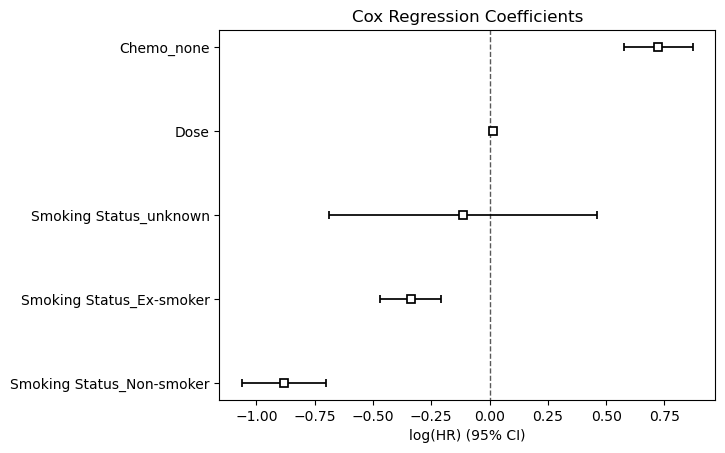

In [37]:
from lifelines import CoxPHFitter #  default non parametric

data = data1.copy()
# one hot encode 'Status'
data["Status"] = np.where(data["Status"]=="Dead", 1, 0)

# Fit the Cox proportional hazards model
# INSTANTIATE, FIT, PREDICT
cph = CoxPHFitter()
# tell the funx what col tells duration and what col is event 
# calculate time (in days but make it int64 type)
data['time'] = (data['Last FU'] - data['RT Start']).dt.days
print(data['time'].dtype)

# cph considers everything a covariate but needs them to be numeric, so tries to one-hot encode everything
# Only keep desired covariates (numeric) + time & event cols
covariates = ['time', 'Status', 'Chemo', 'Smoking Status', 'Dose']  # Add other numeric covariates you want
data_numeric = data[covariates]
# one hot encode; *** drop_first=True *** means to drop the first 'dummy' col and use it as a reference for the other dummy columns
data_numeric = pd.get_dummies(data_numeric, drop_first=True)

cph.fit(data_numeric, duration_col='time', event_col='Status')
# within cph object, will have all the coefficients

# Print the summary of the model
cph.print_summary() # built in summary function 
# could also print specific variable outputs 

# Plot the coefficients
cph.plot()
plt.title('Cox Regression Coefficients')
plt.show()


https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
to validate PH assumptions 

### 3. Random Survival Forests (RSF)
- Build a Random Survival Forest model to predict survival.
- Perform variable importance analysis to identify the most predictive factors.
- Compare the model’s concordance index (C-index) with that of Cox regression

In [ ]:
from sksurv.ensemble import RandomSurvivalForest
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sksurv.util import Surv
# this time using scikit for data prep, so y-variable will already be in compatable format (array)

# Load the dataset
data = data1.copy()
# one hot of event
data["Status"] = np.where(data["Status"]=="Dead", 1, 0)
# adjust time 
data['time'] = (data['Last FU'] - data['RT Start']).dt.days
print(data['time'].dtype)

# set x and y; y = Status, x = all features except Status (but also remove all date cols)
data_x = data.drop(columns=['Status', 'time', 'RT Start', 'Last FU', 'Date of Death', 'Date Local', 'Date Regional', 'Date Distant', 'Date 2nd Ca'])
data_y = Surv.from_dataframe(event='Status', time='time', data=data)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=42)

# One hot encode categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)

# Train a Random Survival Forest model
rsf = RandomSurvivalForest(n_estimators=100, random_state=42)
rsf.fit(X_train, y_train)

# please refer to https://scikit-survival.readthedocs.io/en/stable/user_guide/random-survival-forest.html
# permutation importance: looking at differnet permutations and assessing importance in tree-based funcitonality; what features giving menaingful splits? what features show more importance?
# functionality for random forest classifier had this built in 
result = permutation_importance(rsf, X_train, y_train, n_repeats=15, random_state=42)
feature_importance = pd.DataFrame(
         {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_train.columns,
).sort_values(by="importances_mean", ascending=False)

# Sort by importances_mean and plot
feature_importance = feature_importance.sort_values(by="importances_mean", ascending=False)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(feature_importance.index, feature_importance['importances_mean'], xerr=feature_importance['importances_std'], align='center')
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(rsf.score(X_test, y_test)) #<-- to do 

int64
